## 파이토치 기초(5) - Auto encoder

* day 1 - 텐서와 Autograd : https://dacon.io/codeshare/4478
* day 2 - 신경망모델 구현하기 : https://dacon.io/codeshare/4495
* day 3 - DNN : https://dacon.io/codeshare/4532
* day 4 - CNN : https://dacon.io/codeshare/4537

* 오늘은 입력값만으로 학습하는 오토인코더를 살펴보겠습니다.

* 지도학습은 단순히 말해 입력 x와 정답 y 사이의 관계를 찾는 것이고, 비지도 학습은 정답이 없는 채로 x를 예측합니다.
* x를 예측하고, 신경망에 의미 있는 정보가 쌓이도록 설계된 신경망이 바로 오토인코더입니다. 즉 오토인코더에서는 입력도 x, 정답도 x 입니다.
* 단, 신경망은 범용근사자(univeral function approximator)로서 근사치를 출력하므로 x와 똑같은 출력을 내긴 힘듭니다.
* 그러므로 오찻값에도 x를 얼마나 복원했는지를 뜻하는 복원오차, 혹은 정보손실값(reconstruction loss)이라는 용어를 사용합니다.

* 오토인코더는 입력과 출력의 크기는 같지만 중간으로 갈수록 신경망의 차원이 줄어든다는 것입니다.
* 작은 차원으로 압축된 표현을 잠재변수(latent variable)라 하고, 간단히 z라고도 합니다.
* 잠재 변수의 앞뒤를 구분하여 앞부분을 인코더(encoder), 뒷부분을 디코더(decoder)라고 합니다.인코더는 정보를 받아 압축하고, 디코더는 압축된 표현을 풀어 입력을 복원하는 역할을 합니다.
* 오토인코더에서는 필연적으로 정보의 손실이 일어나지만 이는 중요한 정보만 남겨두는 일종의 데이터 가공이라고 볼 수 있습니다. 이런 특징으로 인해 오토인코더는 주로 복잡한 비선형 데이터의 차원을 줄이는 용도로 쓰입니다.

### 오토인코더로 이미지 특징 추출하기

In [2]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #생성되는 이미지를 관찰하기 위함입니다. 3차원 플롯을 그리는 용도입니다.
from matplotlib import cm # 데이터포인트에 색상을 입히는 것에 사용됩니다.
import numpy as np

In [3]:
# 하이퍼파라미터 준비
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [4]:
# Fashion MNIST 데이터셋 불러오기 (학습데이터만 사용)
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

In [5]:
# 오토인코더 모듈 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        #인코더는 간단한 신경망으로 분류모델처럼 생겼습니다.
        self.encoder = nn.Sequential( # nn.Sequential을 사용해 encoder와 decoder 두 모듈로 묶어줍니다.
            nn.Linear(28*28, 128), #차원을 28*28에서 점차 줄여나갑니다.
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축합니다 (출력값이 바로 잠재변수가 됩니다.)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12), #디코더는 차원을 점차 28*28로 복원합니다.
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력하는 sigmoid()함수를 추가합니다.
        )

    def forward(self, x):
        encoded = self.encoder(x) # encoder는 encoded라는 잠재변수를 만들고
        decoded = self.decoder(encoded) # decoder를 통해 decoded라는 복원이미지를 만듭니다.
        return encoded, decoded

In [6]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005) 
# Adam()을 최적화함수로 사용합니다. Adam은 SGD의 변형함수이며 학습중인 기울기를 참고하여 학습 속도를 자동으로 변화시킵니다.
criterion = nn.MSELoss() #원본값과 디코더에서 나온 값의 차이를 계산하기 위해 평균제곱오차(Mean Squared Loss) 오차함수를 사용합니다.

In [7]:
# 원본 이미지를 시각화 하기 (첫번째 열)
view_data = trainset.data[:5].view(-1, 28*28)
# 복원이 어떻게 되는지 관찰하기 위해 5개의 이미지를 가져와 바로 넣어보겠습니다.
view_data = view_data.type(torch.FloatTensor)/255.
#픽셀의 색상값이 0~255이므로 모델이 인식하는 0부터 1사이의 값으로 만들기 위해 255로 나눠줍니다.

In [8]:
# 학습하기 위한 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE) #x(입력)와 y(대상 레이블)모두 원본이미지(x)인 것을 주의해야 합니다.
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y) # decoded와 원본이미지(y) 사이의 평균제곱오차를 구합니다
        optimizer.zero_grad() #기울기에 대한 정보를 초기화합니다.
        loss.backward() # 기울기를 구합니다.
        optimizer.step() #최적화를 진행합니다.

[Epoch 1]


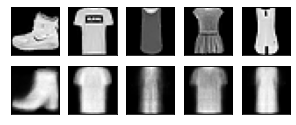

[Epoch 2]


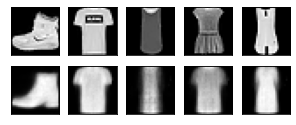

[Epoch 3]


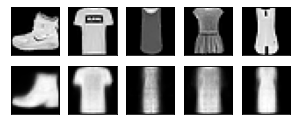

[Epoch 4]


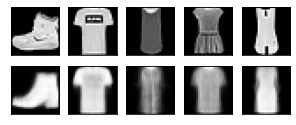

[Epoch 5]


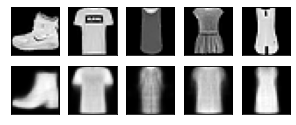

[Epoch 6]


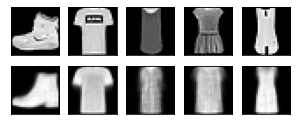

[Epoch 7]


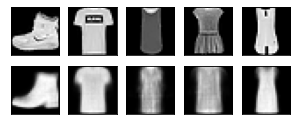

[Epoch 8]


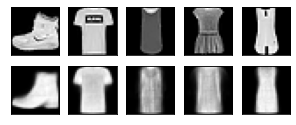

[Epoch 9]


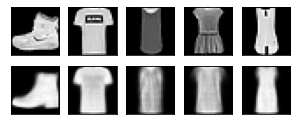

[Epoch 10]


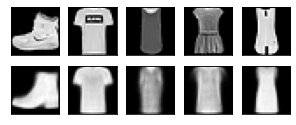

In [9]:
#학습하기
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    # 디코더에서 나온 이미지를 시각화 하기
    # 앞서 시각화를 위해 남겨둔 5개의 이미지를 한 이폭만큼 학습을 마친 모델에 넣어 복원이미지를 만듭니다.
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28)) #파이토치 텐서를 넘파이로 변환합니다.
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28)) 
        # CUDA를 사용하면 모델 출력값이 GPU에 남아있으므로 .to("cpu") 함수로 일반메모리로 가져와 numpy행렬로 변환합니다.
        # cpu를 사용할때에도 같은 코드를 사용해도 무방합니다.
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

### 잠재변수 들여다보기

In [10]:
# 잠재변수를 3D 플롯으로 시각화
view_data = trainset.data[:200].view(-1, 28*28) #원본이미지 200개를 준비합니다
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

C:\Users\syi06\.conda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  from ipykernel import kernelapp as app


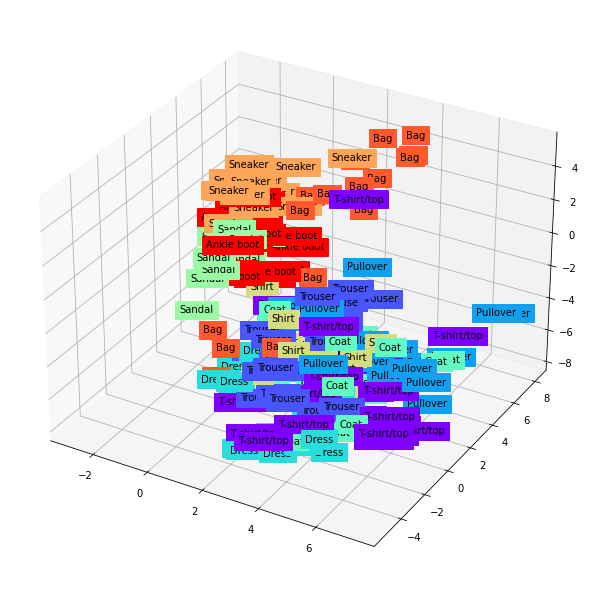

In [11]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy() #잠재변수의 각 차원을 numpy행렬로 변환합니다.

labels = trainset.targets[:200].numpy() #레이블도 넘파이행렬로 변환합니다.

for x, y, z, s in zip(X, Y, Z, labels): #zip()은 같은 길이의 행렬들을 모아 순서대로 묶어줍니다.
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

* 같은 레이블을 가진 이미지의 잠재변수는 확연히 서로 모임을 알 수 있습니다.
* 티셔츠, 드레스, 코트, 셔츠와 같은 윗옷들끼리의 거리는 가깝거나 겹치고, 신발류인 앵클부츠, 샌들, 운동화도 서로 가까이 자리하는 것을 볼 수 있습니다.
* 즉, 비슷한 의미의 이미지라면 공간적으로 더 까갑습니다.

### 오토인코더로 망가진 이미지 복원하기

* 잡음제거 오토인코더(Denoising Autoencoder)는 2008년 몬트리올 대학에서 발표한 논문 "Extracting and Composing Robust Features with Denoising AutoEncoder" 에서 처음 제안되었습니다.

* 앞서 오토인코더는 일종의 "압축"을 한다고 했습니다. 그리고 압축은 데이터의 특성에 중요도로 우선순위를 매기고 낮은 우선순위의 데이터를 버린다는 뜻이기도 합니다.

* 잡음제거 오토인코더의 아이디어는 중요한 특징을 추출하는 오토인코더의 특성을 이용하여 비교적 "덜 중요한 데이터"인 잡음을 버려 원래의 데이터를 복원한다는 것 입니다. 원래 배웠던 오토인코더와 큰 차이점은 없으며, 학습을 할때 입력에 잡음을 더하는 방식으로 복원 능력을 강화한 것이 핵심입니다.

* 앞서 다룬 코드와 동일하며 add_noise() 함수로 학습시 이미지에 노이즈를 더해주는 부분만 추가됐습니다.

In [12]:
# 잡음 더하기
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2 
    # 무작위 작음은 torch.randn() 함수로 만들고 img.size()를 넣어 이미지와 같은 크기의 잡음을 만듭니다.
    # 잡음의 강도는 임의로 0.2로 정했습니다.
    noisy_img = img + noise
    return noisy_img

In [13]:
#학습코드에 노이즈더하기 코드 한줄을 추가합니다.
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        noisy_x = add_noise(x)  # 입력에 노이즈 더하기
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)

        label = label.to(DEVICE)
        encoded, decoded = autoencoder(noisy_x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item() # 이번에는 평균 오찻값을 관찰하겠습니다.
    return avg_loss / len(train_loader)

In [14]:
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print("[Epoch {}] loss:{}".format(epoch, loss))
    # 이번 예제에선 학습시 시각화를 건너 뜁니다

[Epoch 1] loss:0.023051360896083593
[Epoch 2] loss:0.022633396301553574
[Epoch 3] loss:0.022538402441468066
[Epoch 4] loss:0.022369562822983843
[Epoch 5] loss:0.02227465301823578
[Epoch 6] loss:0.022285325544030427
[Epoch 7] loss:0.02221381103496816
[Epoch 8] loss:0.022156562324541846
[Epoch 9] loss:0.02207331597280782
[Epoch 10] loss:0.022045717062329304


In [15]:
# 잡음제거 시각화
# 모델이 학습시 본적이 없는 데이터로 검증하기 위해 테스트 데이터셋을 가져옵니다.
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False, #test데이터셋
    download  = True,
    transform = transforms.ToTensor()
)

# 테스트셋에서 이미지 한장을 가져옵니다.
sample_data = testset.data[0].view(-1, 28*28) #1차원 행렬로 변환합니다
sample_data = sample_data.type(torch.FloatTensor)/255.

# 이미지를 add_noise로 오염시킨 후, 모델에 통과시킵니다.
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x) #인코딩된 것은 무시하고 복원된 이미지만 보기 위해 첫 변수는 "_"로 이름 짓습니다.

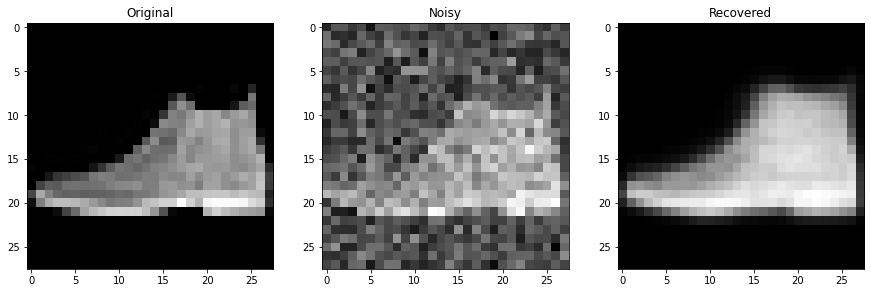

In [16]:
f, a = plt.subplots(1, 3, figsize=(15, 15)) #1행 3열의 표

# 시각화를 위해 넘파이 행렬로 바꿔줍니다.
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# 원본 사진
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# 오염된 원본 사진
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# 복원된 사진
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()

오토인코더의 개념에 대하여 배우고 Fashion MNIST 데이터셋으로 간단하게 구현해보면서 오토인코더가 어떻게 동작하고 어떤 결과를 도출하는지 확인하였습니다.